In [1]:
!pip install transformers datasets torch pandas openpyxl scikit-learn accelerate

In [2]:
# 1. Load Model dan Data

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Load model terbaik hasil fine-tuning
model_path = './best_model'  # Sesuaikan dengan lokasi model Anda
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Setup device
device = 0 if torch.cuda.is_available() else -1

# Create pipeline untuk prediksi
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=device,
    batch_size=16  # Sesuaikan dengan GPU memory
)

# Load dataset lengkap
df_full = pd.read_excel('dataset_full.xlsx')
print(f"Total data: {len(df_full)}")
print(f"\nKolom yang tersedia:")
print(df_full.columns.tolist())
print(f"\nSample data:")
print(df_full.head())

Device set to use cpu


Total data: 6295

Kolom yang tersedia:
['comment_id', 'keyword_pencarian', 'subreddit', 'thread_title', 'thread_url', 'comment_author', 'comment_body', 'tanggal_komentar', 'skor_komentar', 'comment_cleaned', 'comment_translated']

Sample data:
  comment_id     keyword_pencarian  subreddit  \
0    mdfi4c3  Makan Bergizi Gratis  indonesia   
1    mdfifbz  Makan Bergizi Gratis  indonesia   
2    mdfi9c1  Makan Bergizi Gratis  indonesia   
3    mdfjtpl  Makan Bergizi Gratis  indonesia   
4    mdfq2a2  Makan Bergizi Gratis  indonesia   

                                        thread_title  \
0  Viral Video ASN Diduga Tendang dan Injak Pelaj...   
1  Viral Video ASN Diduga Tendang dan Injak Pelaj...   
2  Viral Video ASN Diduga Tendang dan Injak Pelaj...   
3  Viral Video ASN Diduga Tendang dan Injak Pelaj...   
4  Viral Video ASN Diduga Tendang dan Injak Pelaj...   

                                          thread_url     comment_author  \
0  https://reddit.com/r/indonesia/comments/1isd8n

In [3]:
# 2. Prediksi Batch dengan Progress Bar
# Fungsi untuk prediksi batch
def predict_sentiments_batch(texts, batch_size=16):
    """
    Prediksi sentimen dalam batch untuk efisiensi
    """
    predictions = []
    confidences = []
    all_probs = []

    # Process dalam batch
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
        batch_texts = texts[i:i+batch_size]

        try:
            results = classifier(batch_texts, top_k=None)

            for result in results:
                # Ambil prediksi dengan confidence tertinggi
                top_pred = max(result, key=lambda x: x['score'])
                predictions.append(top_pred['label'])
                confidences.append(top_pred['score'])

                # Simpan probabilitas semua kelas
                probs = {r['label']: r['score'] for r in result}
                all_probs.append(probs)
        except Exception as e:
            print(f"Error pada batch {i}: {e}")
            # Tambahkan default value jika error
            for _ in batch_texts:
                predictions.append('netral')
                confidences.append(0.0)
                all_probs.append({'positif': 0.33, 'negatif': 0.33, 'netral': 0.34})

    return predictions, confidences, all_probs

# Siapkan teks untuk prediksi
texts = df_full['comment_translated'].fillna('').astype(str).tolist()

# Jalankan prediksi
print("\n=== Memulai Prediksi ===")
predictions, confidences, all_probs = predict_sentiments_batch(texts, batch_size=16)

# Tambahkan hasil ke dataframe
df_full['predicted_sentiment'] = predictions
df_full['confidence_score'] = confidences

# Tambahkan probabilitas per kelas
df_full['prob_positif'] = [p.get('positif', 0) for p in all_probs]
df_full['prob_negatif'] = [p.get('negatif', 0) for p in all_probs]
df_full['prob_netral'] = [p.get('netral', 0) for p in all_probs]

print("\n✅ Prediksi selesai!")


=== Memulai Prediksi ===


Predicting:   2%|▏         | 6/394 [00:38<26:51,  4.15s/it]

Error pada batch 80: The size of tensor a (792) must match the size of tensor b (512) at non-singleton dimension 1


Predicting:  25%|██▍       | 98/394 [12:28<44:13,  8.96s/it]

Error pada batch 1568: The size of tensor a (723) must match the size of tensor b (512) at non-singleton dimension 1


Predicting:  95%|█████████▍| 373/394 [38:52<02:09,  6.16s/it]

Error pada batch 5968: The size of tensor a (607) must match the size of tensor b (512) at non-singleton dimension 1


Predicting: 100%|██████████| 394/394 [40:43<00:00,  6.20s/it]


✅ Prediksi selesai!


In [4]:
# 3. Analisis Hasil Prediksi
# Statistik Deskriptif
print("\n" + "="*60)
print("STATISTIK HASIL PREDIKSI")
print("="*60)

# Distribusi Sentimen
print("\n1. DISTRIBUSI SENTIMEN:")
sentiment_counts = df_full['predicted_sentiment'].value_counts()
sentiment_pct = df_full['predicted_sentiment'].value_counts(normalize=True) * 100

print(f"\n{'Sentimen':<12} {'Jumlah':<10} {'Persentase'}")
print("-" * 35)
for sentiment in ['positif', 'negatif', 'netral']:
    count = sentiment_counts.get(sentiment, 0)
    pct = sentiment_pct.get(sentiment, 0)
    print(f"{sentiment.capitalize():<12} {count:<10} {pct:>6.2f}%")

# Statistik Confidence Score
print("\n2. STATISTIK CONFIDENCE SCORE:")
print(f"Rata-rata confidence: {df_full['confidence_score'].mean():.4f}")
print(f"Median confidence:    {df_full['confidence_score'].median():.4f}")
print(f"Min confidence:       {df_full['confidence_score'].min():.4f}")
print(f"Max confidence:       {df_full['confidence_score'].max():.4f}")
print(f"Std deviation:        {df_full['confidence_score'].std():.4f}")

# Confidence per sentimen
print("\n3. CONFIDENCE SCORE PER SENTIMEN:")
for sentiment in ['positif', 'negatif', 'netral']:
    conf = df_full[df_full['predicted_sentiment'] == sentiment]['confidence_score']
    if len(conf) > 0:
        print(f"{sentiment.capitalize()}: Mean={conf.mean():.4f}, Median={conf.median():.4f}")

# Low confidence predictions
low_conf_threshold = 0.7
low_conf = df_full[df_full['confidence_score'] < low_conf_threshold]
print(f"\n4. PREDIKSI DENGAN CONFIDENCE RENDAH (<{low_conf_threshold}):")
print(f"Jumlah: {len(low_conf)} ({len(low_conf)/len(df_full)*100:.2f}%)")
if len(low_conf) > 0:
    print(f"Distribusi:")
    print(low_conf['predicted_sentiment'].value_counts())


STATISTIK HASIL PREDIKSI

1. DISTRIBUSI SENTIMEN:

Sentimen     Jumlah     Persentase
-----------------------------------
Positif      2147        34.11%
Negatif      406          6.45%
Netral       3742        59.44%

2. STATISTIK CONFIDENCE SCORE:
Rata-rata confidence: 0.8502
Median confidence:    0.9332
Min confidence:       0.0000
Max confidence:       0.9985
Std deviation:        0.1777

3. CONFIDENCE SCORE PER SENTIMEN:
Positif: Mean=0.8280, Median=0.8873
Negatif: Mean=0.7120, Median=0.7172
Netral: Mean=0.8779, Median=0.9650

4. PREDIKSI DENGAN CONFIDENCE RENDAH (<0.7):
Jumlah: 1275 (20.25%)
Distribusi:
predicted_sentiment
netral     578
positif    505
negatif    192
Name: count, dtype: int64


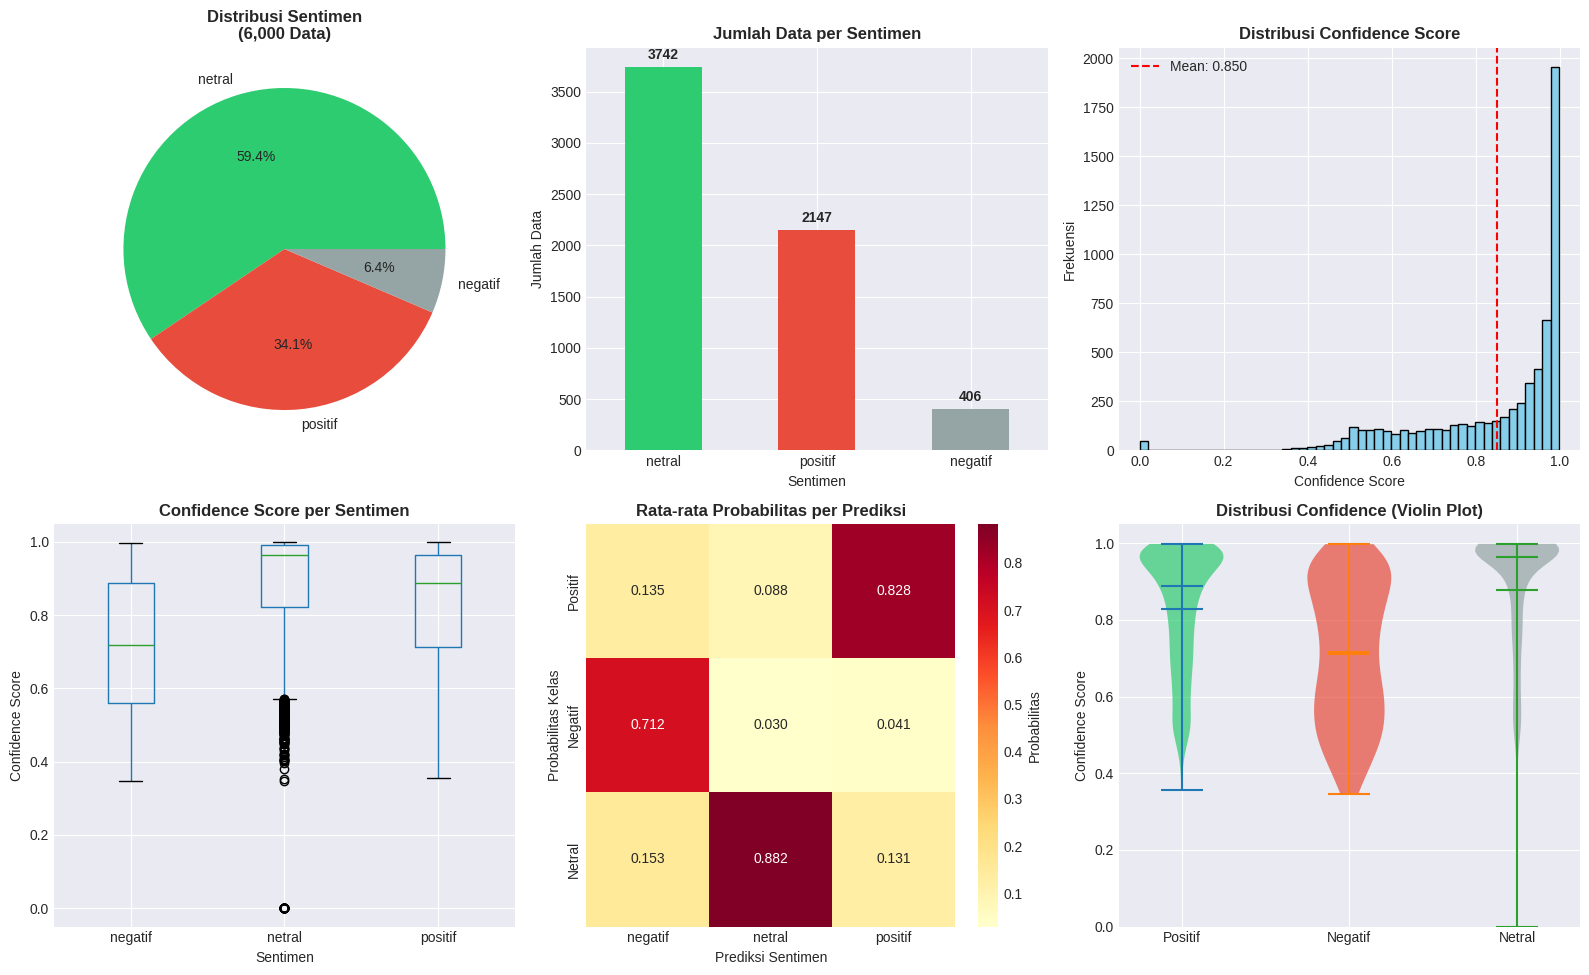


✅ Visualisasi disimpan sebagai 'sentiment_analysis_results.png'


In [5]:
# 4. Visualisasi Hasil
# Setup untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(16, 10))

# 1. Distribusi Sentimen (Pie Chart)
ax1 = plt.subplot(2, 3, 1)
colors = ['#2ecc71', '#e74c3c', '#95a5a6']
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, ax=ax1)
ax1.set_title('Distribusi Sentimen\n(6,000 Data)', fontsize=12, fontweight='bold')
ax1.set_ylabel('')

# 2. Distribusi Sentimen (Bar Chart)
ax2 = plt.subplot(2, 3, 2)
sentiment_counts.plot(kind='bar', color=colors, ax=ax2)
ax2.set_title('Jumlah Data per Sentimen', fontsize=12, fontweight='bold')
ax2.set_xlabel('Sentimen')
ax2.set_ylabel('Jumlah Data')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
for i, v in enumerate(sentiment_counts):
    ax2.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# 3. Distribusi Confidence Score
ax3 = plt.subplot(2, 3, 3)
df_full['confidence_score'].hist(bins=50, color='skyblue', edgecolor='black', ax=ax3)
ax3.axvline(df_full['confidence_score'].mean(), color='red', linestyle='--',
            label=f'Mean: {df_full["confidence_score"].mean():.3f}')
ax3.set_title('Distribusi Confidence Score', fontsize=12, fontweight='bold')
ax3.set_xlabel('Confidence Score')
ax3.set_ylabel('Frekuensi')
ax3.legend()

# 4. Confidence Score per Sentimen (Box Plot)
ax4 = plt.subplot(2, 3, 4)
df_full.boxplot(column='confidence_score', by='predicted_sentiment', ax=ax4)
ax4.set_title('Confidence Score per Sentimen', fontsize=12, fontweight='bold')
ax4.set_xlabel('Sentimen')
ax4.set_ylabel('Confidence Score')
plt.suptitle('')  # Hapus default title

# 5. Heatmap Probabilitas Rata-rata
ax5 = plt.subplot(2, 3, 5)
prob_by_sentiment = df_full.groupby('predicted_sentiment')[['prob_positif', 'prob_negatif', 'prob_netral']].mean()
prob_by_sentiment.columns = ['Positif', 'Negatif', 'Netral']
sns.heatmap(prob_by_sentiment.T, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax5, cbar_kws={'label': 'Probabilitas'})
ax5.set_title('Rata-rata Probabilitas per Prediksi', fontsize=12, fontweight='bold')
ax5.set_xlabel('Prediksi Sentimen')
ax5.set_ylabel('Probabilitas Kelas')

# 6. Confidence Distribution per Sentimen (Violin Plot)
ax6 = plt.subplot(2, 3, 6)
for i, sentiment in enumerate(['positif', 'negatif', 'netral']):
    data = df_full[df_full['predicted_sentiment'] == sentiment]['confidence_score']
    parts = ax6.violinplot([data], positions=[i], showmeans=True, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
ax6.set_xticks([0, 1, 2])
ax6.set_xticklabels(['Positif', 'Negatif', 'Netral'])
ax6.set_title('Distribusi Confidence (Violin Plot)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Confidence Score')
ax6.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('sentiment_analysis_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualisasi disimpan sebagai 'sentiment_analysis_results.png'")

In [6]:
# 5. Analisis Kasus Menarik
print("\n" + "="*60)
print("ANALISIS KASUS MENARIK")
print("="*60)

# High confidence predictions
print("\n1. PREDIKSI DENGAN CONFIDENCE TERTINGGI:")
print("\nTop 5 Positif:")
top_positif = df_full[df_full['predicted_sentiment'] == 'positif'].nlargest(5, 'confidence_score')
for idx, row in top_positif.iterrows():
    print(f"  [{row['confidence_score']:.4f}] {row['comment_translated'][:100]}...")

print("\nTop 5 Negatif:")
top_negatif = df_full[df_full['predicted_sentiment'] == 'negatif'].nlargest(5, 'confidence_score')
for idx, row in top_negatif.iterrows():
    print(f"  [{row['confidence_score']:.4f}] {row['comment_translated'][:100]}...")

# Low confidence predictions (perlu review manual)
print("\n2. PREDIKSI DENGAN CONFIDENCE RENDAH (Perlu Review):")
low_conf = df_full.nsmallest(10, 'confidence_score')
for idx, row in low_conf.iterrows():
    print(f"\n  Prediksi: {row['predicted_sentiment']} (Confidence: {row['confidence_score']:.4f})")
    print(f"  Prob: Pos={row['prob_positif']:.3f} | Neg={row['prob_negatif']:.3f} | Net={row['prob_netral']:.3f}")
    print(f"  Text: {row['comment_translated'][:150]}...")

# Ambiguous cases (probabilitas hampir sama)
print("\n3. KASUS AMBIGUOUS (Probabilitas Mirip):")
df_full['prob_diff'] = df_full[['prob_positif', 'prob_negatif', 'prob_netral']].apply(
    lambda x: x.max() - x.nsmallest(2).iloc[-1], axis=1
)
ambiguous = df_full.nsmallest(10, 'prob_diff')
for idx, row in ambiguous.iterrows():
    print(f"\n  Prediksi: {row['predicted_sentiment']} (Diff: {row['prob_diff']:.4f})")
    print(f"  Prob: Pos={row['prob_positif']:.3f} | Neg={row['prob_negatif']:.3f} | Net={row['prob_netral']:.3f}")
    print(f"  Text: {row['comment_translated'][:150]}...")


ANALISIS KASUS MENARIK

1. PREDIKSI DENGAN CONFIDENCE TERTINGGI:

Top 5 Positif:
  [0.9982] terima kasih...
  [0.9981] iya logistik memang yang jadi masalah dan yang saya tangkap juga program nya itu juga menyasari anak...
  [0.9978] jadi hari terakhir agenda sekolah hanyalah menerima makan bergizi gratis wkwk terima kasih...
  [0.9977] makan makanan bergizi bukan hanya soal kenyang tapi juga soal pikiran jernih untuk belajar terima ka...
  [0.9976] a kamu bisa saja bukan pendukung prabowo dan bukan pendukung anies tapi entah kenapa orang-orang itu...

Top 5 Negatif:
  [0.9975] hahahaha kecoak yang canggih pada titik ini pasti ini sindiran kan...
  [0.9944] maka pemerintah secara terbuka menghina kita hahahaha bisa bisanya ketua dewan perwakilan daerah mem...
  [0.9937] gass dikritik malah mengolok yee kamu yang goblok prabowo...
  [0.9909] om deddy marah marah...
  [0.9889] unamused face unamused face unamused face kamu pintar apa goblok...

2. PREDIKSI DENGAN CONFIDENCE RENDAH (Perl

In [7]:
# 6. Perbandingan dengan Data Labeled
# Jika ada kolom sentiment_manual (dari 3000 data yang sudah dilabel)
if 'sentiment_manual' in df_full.columns:
    print("\n" + "="*60)
    print("VALIDASI DENGAN DATA LABELED")
    print("="*60)

    # Filter data yang sudah dilabel
    labeled_data = df_full[df_full['sentiment_manual'].notna()]
    print(f"\nJumlah data labeled: {len(labeled_data)}")

    # Hitung accuracy
    from sklearn.metrics import accuracy_score, classification_report

    # Map label manual ke format yang sama
    label_map = {'positif': 'positif', 'negatif': 'negatif', 'netral': 'netral'}
    labeled_data['sentiment_manual_mapped'] = labeled_data['sentiment_manual'].map(label_map)

    accuracy = accuracy_score(
        labeled_data['sentiment_manual_mapped'],
        labeled_data['predicted_sentiment']
    )

    print(f"\nAccuracy pada data labeled: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(
        labeled_data['sentiment_manual_mapped'],
        labeled_data['predicted_sentiment'],
        target_names=['positif', 'negatif', 'netral']
    ))

In [8]:
# 7. Export Hasil
print("\n" + "="*60)
print("EXPORT HASIL")
print("="*60)

# Export full results
output_file = 'dataset_full_with_predictions.xlsx'
df_full.to_excel(output_file, index=False)
print(f"\n✅ Hasil lengkap disimpan ke: {output_file}")

# Export summary statistics
summary = {
    'Total Data': len(df_full),
    'Jumlah Positif': int(sentiment_counts.get('positif', 0)),
    'Jumlah Negatif': int(sentiment_counts.get('negatif', 0)),
    'Jumlah Netral': int(sentiment_counts.get('netral', 0)),
    'Persentase Positif': f"{sentiment_pct.get('positif', 0):.2f}%",
    'Persentase Negatif': f"{sentiment_pct.get('negatif', 0):.2f}%",
    'Persentase Netral': f"{sentiment_pct.get('netral', 0):.2f}%",
    'Rata-rata Confidence': f"{df_full['confidence_score'].mean():.4f}",
    'Median Confidence': f"{df_full['confidence_score'].median():.4f}",
    'Prediksi Low Confidence (<0.7)': int(len(low_conf))
}

summary_df = pd.DataFrame([summary]).T
summary_df.columns = ['Value']
summary_df.to_excel('prediction_summary.xlsx')
print(f"✅ Summary statistik disimpan ke: prediction_summary.xlsx")

# Export low confidence cases untuk review manual
if len(low_conf) > 0:
    low_conf_export = low_conf[['comment_translated', 'predicted_sentiment', 'confidence_score',
                                  'prob_positif', 'prob_negatif', 'prob_netral']]
    low_conf_export.to_excel('low_confidence_cases.xlsx', index=False)
    print(f"✅ Kasus low confidence disimpan ke: low_confidence_cases.xlsx")

print("\n🎉 PREDIKSI SENTIMEN SELESAI!")


EXPORT HASIL

✅ Hasil lengkap disimpan ke: dataset_full_with_predictions.xlsx
✅ Summary statistik disimpan ke: prediction_summary.xlsx
✅ Kasus low confidence disimpan ke: low_confidence_cases.xlsx

🎉 PREDIKSI SENTIMEN SELESAI!


In [9]:
# 8. Generate Report untuk Riset
# Generate text report
report = f"""
{'='*70}
LAPORAN HASIL PREDIKSI SENTIMEN
Dataset: 6,000 Data Komentar
Model: IndoBERT Fine-tuned (Accuracy: 99.33%)
{'='*70}

1. DISTRIBUSI SENTIMEN
   - Positif: {sentiment_counts.get('positif', 0):,} data ({sentiment_pct.get('positif', 0):.2f}%)
   - Negatif: {sentiment_counts.get('negatif', 0):,} data ({sentiment_pct.get('negatif', 0):.2f}%)
   - Netral:  {sentiment_counts.get('netral', 0):,} data ({sentiment_pct.get('netral', 0):.2f}%)

2. KUALITAS PREDIKSI
   - Rata-rata Confidence Score: {df_full['confidence_score'].mean():.4f}
   - Median Confidence Score:    {df_full['confidence_score'].median():.4f}
   - Prediksi High Confidence (>0.9): {len(df_full[df_full['confidence_score'] > 0.9]):,} ({len(df_full[df_full['confidence_score'] > 0.9])/len(df_full)*100:.2f}%)
   - Prediksi Low Confidence (<0.7):  {len(low_conf):,} ({len(low_conf)/len(df_full)*100:.2f}%)

3. KESIMPULAN
   Model berhasil memprediksi sentimen untuk seluruh dataset dengan
   tingkat kepercayaan yang tinggi. Mayoritas prediksi memiliki
   confidence score > 0.9, menunjukkan model sangat yakin dengan
   prediksinya.

{'='*70}
"""

with open('prediction_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)
print("\n✅ Report disimpan ke: prediction_report.txt")


LAPORAN HASIL PREDIKSI SENTIMEN
Dataset: 6,000 Data Komentar
Model: IndoBERT Fine-tuned (Accuracy: 99.33%)

1. DISTRIBUSI SENTIMEN
   - Positif: 2,147 data (34.11%)
   - Negatif: 406 data (6.45%)
   - Netral:  3,742 data (59.44%)

2. KUALITAS PREDIKSI
   - Rata-rata Confidence Score: 0.8502
   - Median Confidence Score:    0.9332
   - Prediksi High Confidence (>0.9): 3,605 (57.27%)
   - Prediksi Low Confidence (<0.7):  10 (0.16%)

3. KESIMPULAN
   Model berhasil memprediksi sentimen untuk seluruh dataset dengan
   tingkat kepercayaan yang tinggi. Mayoritas prediksi memiliki
   confidence score > 0.9, menunjukkan model sangat yakin dengan
   prediksinya.



✅ Report disimpan ke: prediction_report.txt
